<!DOCTYPE html>
<html>
<head>
<style>
    .header-banner {
        background-color: white;
        color: black; 
        padding: 1rem; 
        font-family: 'Nunito', sans-serif;
    }
    .header-content {
        max-width: 2000px;
        margin: 0 auto;
        display: flex;
        align-items: center;
        gap: 2rem;
    }
    .logo {
        max-width: 160px;
    }
    .text-content {
        flex: 1;
    }
    .text-content h1 {
        font-size: 34px;
        margin: 0 0 10px;
        font-weight: 700;
        color: #7e4d02ff;
        border-bottom: 2px solid #e5c120ff;
        padding-bottom: 10px;
    }
    .text-content h2 {
        font-size: 21px;
        margin: 0 0 5px;
        font-weight: 600;
        color: #222;
    }
    .member-list {
        display: grid;
        grid-template-columns: repeat(2, auto);
        gap: 6px 40px;
        font-size: 17px;
        color: #444;
    }
    .member {
        position: relative;
        padding-left: 20px;
    }
</style>
<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Nunito:wght@400;700&display=swap" rel="stylesheet">
</head>
<body>

<header class="header-banner">
    <div class="header-content">
        <img src="https://i.ibb.co/JBPWVYR/Logo-Nova-IMS-Black.png" alt="NOVA IMS Logo" class="logo">
        <div class="text-content">
            <h1>Cars 4 You: Expediting Car Evaluations with ML</h1>
            <h2>Group 37 - Part 2: Regression Benchmarking & Optimization</h2>
            <div class="member-list">
                <div class="member">Filipa Pereira, 20240509</div>
                <div class="member">Gonçalo Silva, 20250354</div>
                <div class="member">Marta La Feria, 20211051 </div>
                <div class="member">Tomás Coroa, 20250394 </div>
            </div>
        </div>
    </div>
</header>

</body>
</html>

---
## Table of Contents

1. [Setup & Data Loading](#1-setup)
2. [Feature Selection](#2-feature-selection)
3. [Regression Benchmarking](#3-benchmarking)
4. [Model Optimization - Ensemble & Stacking](#4-optimization)
5. [Deployment - Final Submission](#5-deployment)


---

<a id='1-setup'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>1 | Setup & Data Loading</b></span>
    </h1>
</div>

### 1.1 Import Libraries

In [3]:
# Standard library
from itertools import combinations

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy.stats import ttest_ind, chi2_contingency, f_oneway

# Sklearn - Base
from sklearn.base import clone
from sklearn.model_selection import ParameterGrid

# Sklearn - Feature Selection
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_regression

# Sklearn - Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    ExtraTreesRegressor, 
    GradientBoostingRegressor,
    StackingRegressor
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Sklearn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    root_mean_squared_error, 
    mean_pinball_loss, 
    make_scorer
)

# Custom utilities
import utils

# MLxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


# Plot style
palette = ['#5C4212','#a92f02', '#a55b1bf9', '#b08972', '#e3a76c', '#e5c120','#f39c06','#f2e209']

### 1.2 Load Data

In [4]:
# Load dictionary for brand/model cleaning
brand_model_dic = pd.read_parquet("./project_data/brand_model_dic.parquet", engine="pyarrow")

# Load the datasets (train, validation, test)
X_train_scaled = pd.read_parquet("./project_data/X_train_scaled.parquet", engine="pyarrow")
X_val_scaled   = pd.read_parquet("./project_data/X_val_scaled.parquet",   engine="pyarrow")
X_test_scaled  = pd.read_parquet("./project_data/X_test_scaled.parquet",  engine="pyarrow")

y_train = pd.read_parquet("./project_data/y_train.parquet", engine="pyarrow").squeeze("columns")
y_val   = pd.read_parquet("./project_data/y_val.parquet",   engine="pyarrow").squeeze("columns")

# Set carID as index
X_train_scaled, X_val_scaled, X_test_scaled = [d.set_index('carID') for d in (X_train_scaled, X_val_scaled, X_test_scaled)]
y_train, y_val = [d.set_index('carID') for d in (y_train, y_val)]

print(f"Train: {X_train_scaled.shape[0]:,} rows, {X_train_scaled.shape[1]} features")
print(f"Val:   {X_val_scaled.shape[0]:,} rows")
print(f"Test:  {X_test_scaled.shape[0]:,} rows")

Train: 60,763 rows, 38 features
Val:   15,193 rows
Test:  32,567 rows


In [8]:
# Prepare target arrays and combined datasets
all_features = list(X_train_scaled.columns)

# Target arrays
y_train_array = y_train['price'].values if isinstance(y_train, pd.DataFrame) else y_train.values.ravel()
y_val_array   = y_val['price'].values if isinstance(y_val, pd.DataFrame) else y_val.values.ravel()

# Log transformation of target (reduces impact of outliers)
y_train_log = np.log1p(y_train_array)
y_val_log   = np.log1p(y_val_array)

# Combined train+val for final model training
X_train_full_scaled   = pd.concat([X_train_scaled, X_val_scaled], axis=0)
y_train_full_array    = np.concatenate([y_train_array, y_val_array])
y_train_full_log      = np.concatenate([y_train_log, y_val_log])

print(f"Train samples: {len(y_train_array):,}")
print(f"Val samples:   {len(y_val_array):,}")
print(f"Full samples:  {len(y_train_full_array):,}")

Train samples: 60,763
Val samples:   15,193
Full samples:  75,956


<a id='2-feature-selection'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>2 | Feature Selection</b></span>
    </h1>
</div>

### 2.1 Business Based

In [4]:
X_train_scaled = X_train_scaled.drop(columns='paintQuality%', errors='ignore')
X_val_scaled =X_val_scaled.drop(columns='paintQuality%', errors='ignore')
X_test_scaled = X_test_scaled.drop(columns='paintQuality%', errors='ignore')

### 2.2 Variance Threshold

In [5]:
# Get rid of variables with variance close to zero (<= 0.01)
vart = VarianceThreshold(threshold=0.01)

#fit
X_train_sel = vart.fit(X_train_scaled)

# Get low variance columns and print them
low_variance = X_train_scaled.columns[vart.variances_ <= 0.01]
print("Number of features with variance closer to zero:", len(low_variance))
print("Features with variance closer to zero:")
for col in low_variance:
    print(f"{col}: {vart.variances_[X_train_scaled.columns.get_loc(col)]:.4f}")

# Drop low variance columns from train, val and test sets
X_train_scaled = X_train_scaled.drop(columns=low_variance, errors='ignore')
X_val_scaled = X_val_scaled.drop(columns=low_variance, errors='ignore')
X_test_scaled = X_test_scaled.drop(columns=low_variance, errors='ignore')

Number of features with variance closer to zero: 1
Features with variance closer to zero:
hasDamage: 0.0000


### 2.3 Correlation Indices with price

In [6]:
# Correlação de cada feature com o target (price)
cor_with_target = pd.concat([X_train_scaled, y_train], axis=1).corr(method='spearman')['price'].drop('price')

# Criar DataFrame ordenado por valor absoluto
cor_df = pd.DataFrame({
    'Feature': cor_with_target.index,
    'Correlation': cor_with_target.values,
    'Abs_Correlation': np.abs(cor_with_target.values)
}).sort_values('Abs_Correlation', ascending=False).reset_index(drop=True)

# Mostrar
print("=== Correlation with Price (Spearman) ===")
display(cor_df)

# Destacar features com baixa correlação (|corr| < 0.1)
low_corr = cor_df[cor_df['Abs_Correlation'] < 0.1]
print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")
display(low_corr)

<>:17: SyntaxWarning: invalid escape sequence '\ '
<>:17: SyntaxWarning: invalid escape sequence '\ '
C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11816\264488923.py:17: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Features with |corr| < 0.1 ({len(low_corr)}):")


=== Correlation with Price (Spearman) ===


,Feature,Correlation,Abs_Correlation
0,model_mean_price,0.777850,0.777850
1,mpg_per_liter,-0.601650,0.601650
2,age,-0.595554,0.595554
3,age_squared,-0.595554,0.595554
4,brand_mean_price,0.580219,0.580219
5,transmission_manual,-0.579835,0.579835
6,age_mileage_interaction,-0.570210,0.570210
7,engineSize,0.562352,0.562352
8,brand_price_std,0.547286,0.547286
9,premium_brand_engine_size_interaction,0.545937,0.545937


\ Features with |corr| < 0.1 (14):


,Feature,Correlation,Abs_Correlation
22,fuelType_hybrid,0.073975,0.073975
23,mpg_is_missing,0.051698,0.051698
24,tax_is_missing,0.050209,0.050209
25,brand_segment_mid_range,-0.046736,0.046736
26,tax_per_engine,-0.040485,0.040485
27,brand_popularity,-0.015477,0.015477
28,fuelType_other,0.007272,0.007272
29,engineSize_is_missing,-0.004617,0.004617
30,transmission_other,0.004114,0.004114
31,year_is_missing,0.003742,0.003742


In [7]:
drop_features = ['mpg_is_missing', 'tax_is_missing', 'fuelTyoe_other', 'engineSize_is_missing', 'transmission_other', 'year_is_missing', 
                 'transmission_unknown', 'fuelType_unknown']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.4 Statistical Hypothesis Testing - ANOVA

In [8]:
bin_cols = [c for c in X_train_scaled.columns if X_train_scaled[c].dropna().nunique() == 2]

X_train_cat = X_train_scaled
for c in bin_cols:
    X_train_cat[c] = X_train_scaled[c].astype('category')

alpha = 0.01

ANOVA_COLS = X_train_cat.columns.tolist() 

anova_results = []
y_price = y_price = y_train['price'].copy()

for col in ANOVA_COLS:
    # Prepare data for ANOVA test
    temp_df = pd.DataFrame({'category': X_train_cat[col], 'price': y_price}).dropna()
    
    # Get price lists for each category
    # If the column has few categories, use all
    groups = [temp_df['price'][temp_df['category'] == category] 
              for category in temp_df['category'].unique()]
    
    # Execute the ANOVA Test
    if len(groups) > 1 and all(len(g) > 0 for g in groups):
        f_stat, p_value = f_oneway(*groups)
        
        #if p < alpha, reject H0 (group means are different) which means the variable is PREDICTIVE
        decision = "predictive" if p_value < alpha else "NOT predictive"
        
        # Calculate mean prices per category
        mean_prices = temp_df.groupby('category')['price'].mean().round(2).to_dict()
    else:
        f_stat, p_value = np.nan, np.nan
        decision = "single group"
        mean_prices = {}

    anova_results.append({
        "Variable": col,
        "Test": "ANOVA",
        "F_Stat": f_stat,
        "p_value": p_value,
        "Decision": decision
    })

# Convert to DataFrame for easy visualization
df_anova = pd.DataFrame(anova_results).sort_values('p_value', na_position='last').reset_index(drop=True)
pd.set_option('display.max_rows', None)
display(df_anova)
pd.reset_option('display.max_rows')

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_11816\69515301.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_prices = temp_df.groupby('category')['price'].mean().round(2).to_dict()


,Variable,Test,F_Stat,p_value,Decision
0,tax,ANOVA,2.814569,0.000000e+00,predictive
1,mpg,ANOVA,7.227783,0.000000e+00,predictive
2,engineSize,ANOVA,42.531365,0.000000e+00,predictive
3,brand_price_std,ANOVA,2772.670693,0.000000e+00,predictive
4,model_popularity,ANOVA,483.630514,0.000000e+00,predictive
5,brand_popularity,ANOVA,2772.670693,0.000000e+00,predictive
6,age_squared,ANOVA,1049.809097,0.000000e+00,predictive
7,age,ANOVA,1049.809097,0.000000e+00,predictive
8,low_mileage,ANOVA,13882.805441,0.000000e+00,predictive
9,high_mileage,ANOVA,6023.465580,0.000000e+00,predictive


In [9]:
drop_features = ['fuelType_other', 'previousOwners', 'fuelType_electric']

for df in [X_train_scaled, X_val_scaled, X_test_scaled]:
    df.drop(columns=drop_features, inplace=True, errors='ignore')

### 2.2 Calculate Feature Importance per Model

In [10]:
# Lasso Regularization (L1) 
lasso_model = Lasso(alpha=1.0, random_state=37, max_iter=10000)
lasso_model.fit(X_train_scaled, y_train_array)
lasso_coefs = pd.Series(lasso_model.coef_, index=X_train_scaled.columns)
lasso_importance = lasso_coefs.abs().sort_values(ascending=False)

# Ridge Regularization (L2) 
ridge_model = Ridge(alpha=1.0, random_state=37)
ridge_model.fit(X_train_scaled, y_train_array)
ridge_coefs = pd.Series(ridge_model.coef_, index=X_train_scaled.columns)
ridge_importance = ridge_coefs.abs().sort_values(ascending=False)

# GB - Native Feature Importance
gb_base = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=37)
gb_base.fit(X_train_scaled, y_train_array)
gb_importance = pd.Series(gb_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# RF - Native Feature Importance
rf_base = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=37, n_jobs=-1)
rf_base.fit(X_train_scaled, y_train_array)
rf_importance = pd.Series(rf_base.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)

# KNN - Mutual Information (captures non-linear relationships)
mi_scores = mutual_info_regression(X_train_scaled, y_train_array, random_state=37)
knn_importance = pd.Series(mi_scores, index=X_train_scaled.columns).sort_values(ascending=False)

#Features eliminated by lasso
lasso_eliminated = lasso_coefs[lasso_coefs == 0].index.tolist()
if lasso_eliminated:
    print(f"\n Features eliminated by Lasso: {lasso_eliminated}")
else:
    print(f"\n Lasso kept all features")

print("\n Feature importance calculated for all methods")


 Features eliminated by Lasso: ['brand_mean_price']

 Feature importance calculated for all methods


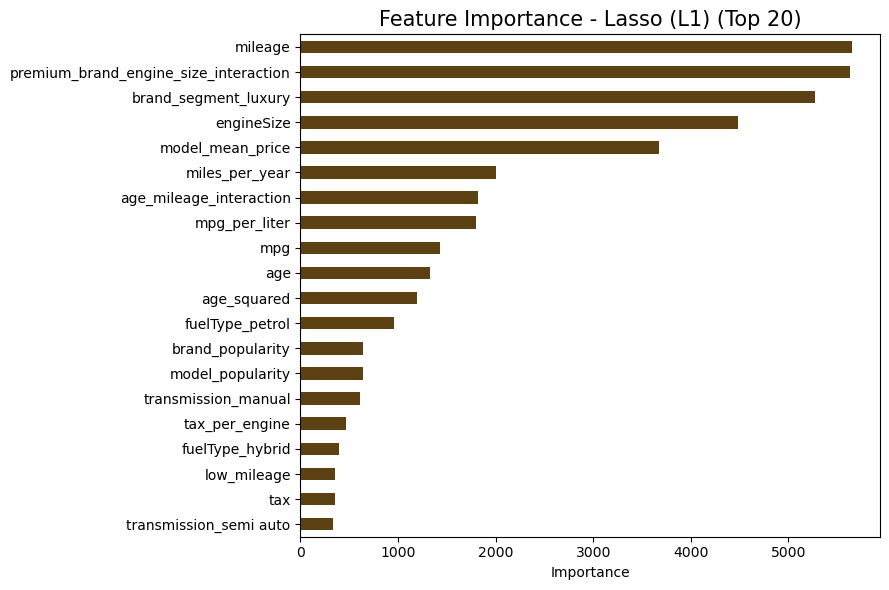


------------------------------------------------------------
MODEL: Lasso (L1)
Threshold: 1541.6887
Selected: 8 features
Features: ['mileage', 'engineSize', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'model_mean_price', 'brand_segment_luxury']
------------------------------------------------------------



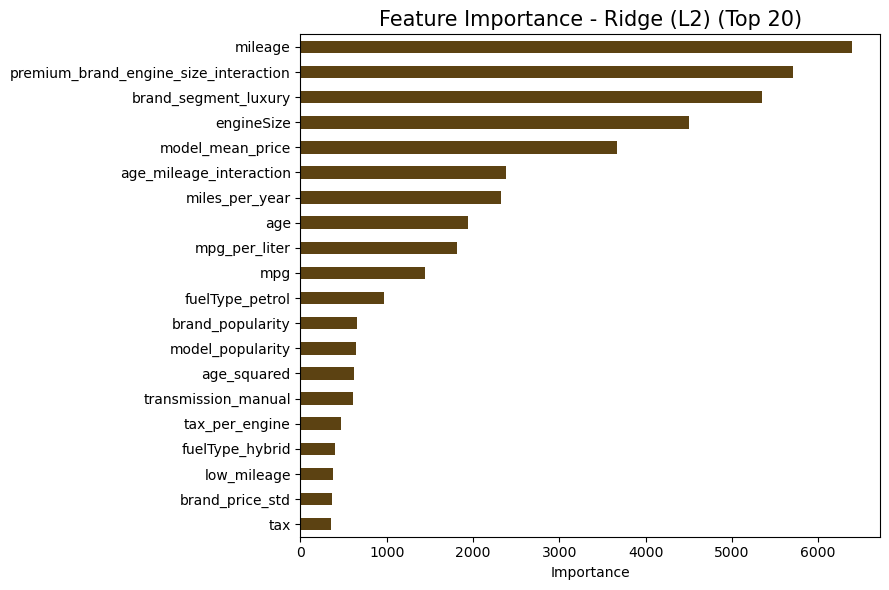


------------------------------------------------------------
MODEL: Ridge (L2)
Threshold: 1615.6621
Selected: 9 features
Features: ['mileage', 'engineSize', 'age', 'miles_per_year', 'age_mileage_interaction', 'premium_brand_engine_size_interaction', 'mpg_per_liter', 'model_mean_price', 'brand_segment_luxury']
------------------------------------------------------------



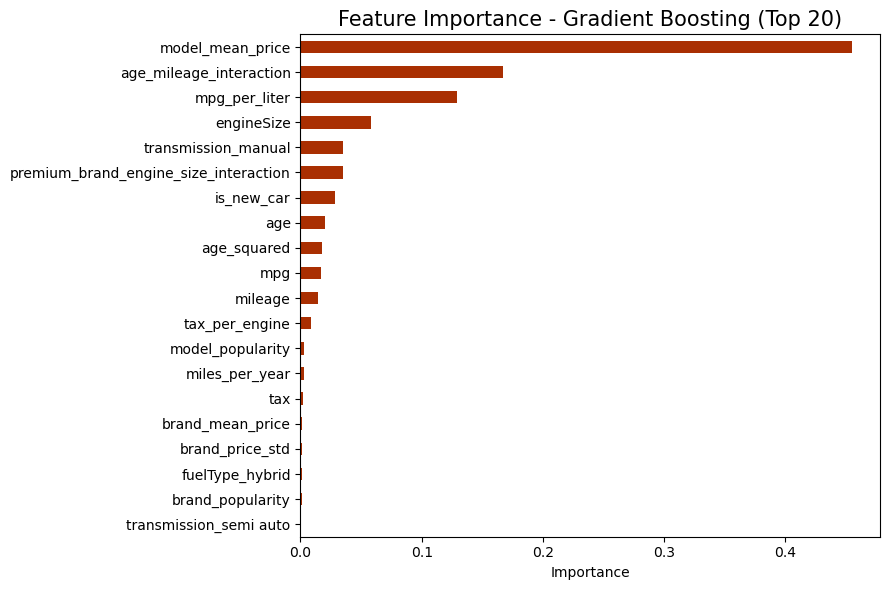


------------------------------------------------------------
MODEL: Gradient Boosting
Threshold: 0.0385
Selected: 4 features
Features: ['model_mean_price', 'age_mileage_interaction', 'mpg_per_liter', 'engineSize']
------------------------------------------------------------



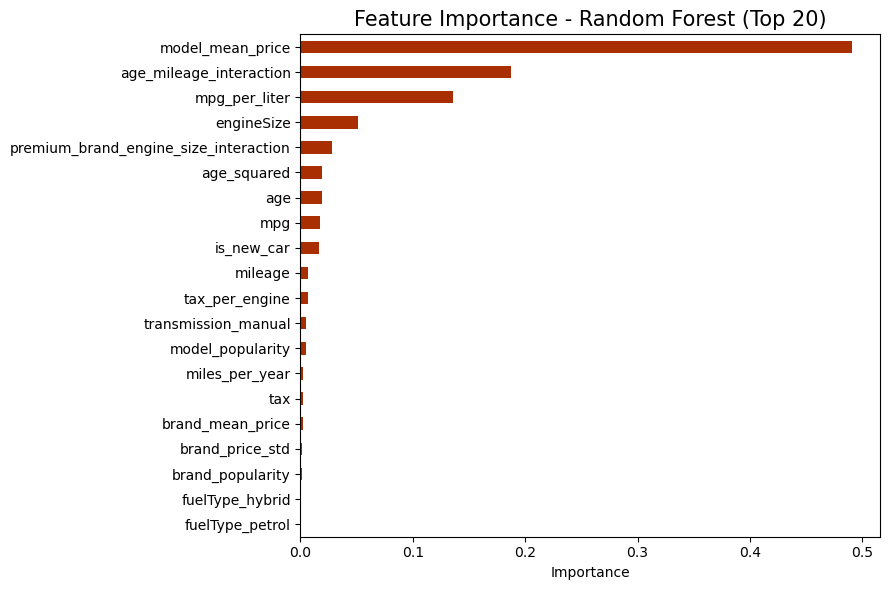


------------------------------------------------------------
MODEL: Random Forest
Threshold: 0.0385
Selected: 4 features
Features: ['model_mean_price', 'age_mileage_interaction', 'mpg_per_liter', 'engineSize']
------------------------------------------------------------



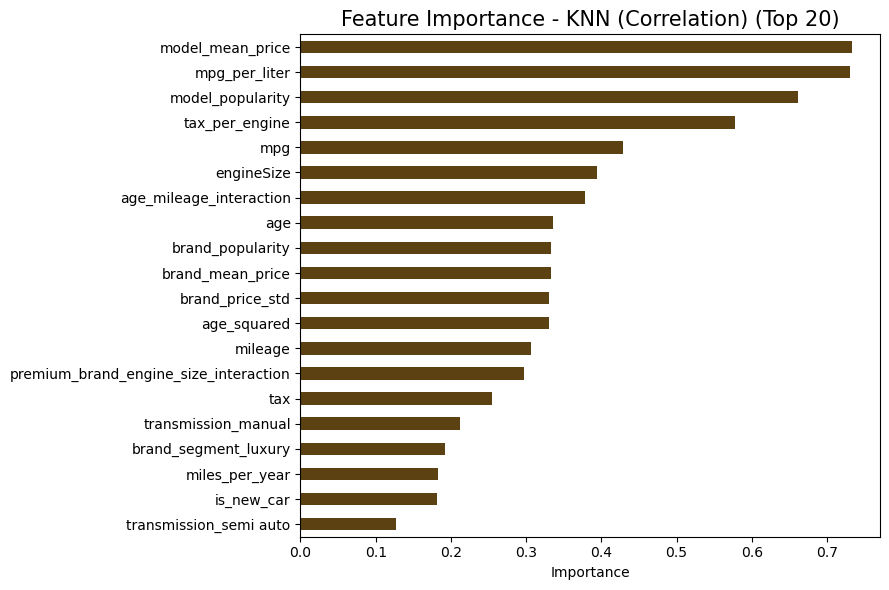


------------------------------------------------------------
MODEL: KNN (Correlation)
Threshold: 0.0385
Selected: 4 features
Features: ['model_mean_price', 'age_mileage_interaction', 'mpg_per_liter', 'engineSize']
------------------------------------------------------------



['model_mean_price', 'age_mileage_interaction', 'mpg_per_liter', 'engineSize']

In [11]:
# Plot feature importance
utils.plot_importance_unified(palette, abs(lasso_coefs), "Lasso (L1)", is_tree_model=False)
utils.print_selection_results(abs(lasso_coefs), "Lasso (L1)")

utils.plot_importance_unified(palette, abs(ridge_coefs), "Ridge (L2)", is_tree_model=False) 
utils.print_selection_results(abs(ridge_coefs), "Ridge (L2)")

utils.plot_importance_unified(palette, gb_importance, "Gradient Boosting", is_tree_model=True)
utils.print_selection_results(rf_importance, "Gradient Boosting")

utils.plot_importance_unified(palette, rf_importance, "Random Forest", is_tree_model=True)
utils.print_selection_results(rf_importance, "Random Forest")

utils.plot_importance_unified(palette, knn_importance, "KNN (Correlation)", is_tree_model=False)
utils.print_selection_results(rf_importance, "KNN (Correlation)")

### 2.3 Select Optimal Number of Features

We test different numbers of top features to find the optimal subset for each model.

In [12]:
# Create ranks for each model (1 = most important)
gb_ranks = pd.Series(range(1, len(gb_importance) + 1), index=gb_importance.index)
rf_ranks = pd.Series(range(1, len(rf_importance) + 1), index=rf_importance.index)
knn_ranks = pd.Series(range(1, len(knn_importance) + 1), index=knn_importance.index)

# Combine and sort
feature_ranks = (gb_ranks + rf_ranks + knn_ranks).sort_values()

# Final sorted list
ranked_features = feature_ranks.index.tolist()
print(ranked_features)

# Model configurations
model_configs = {
    'GB': lambda: GradientBoostingRegressor(n_estimators=200, max_depth=7, learning_rate=0.06, random_state=37),
    'RF': lambda: RandomForestRegressor(n_estimators=100, max_depth=15, random_state=37, n_jobs=-1),
    'KNN': lambda: KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=-1)
}

# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': ranked_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

# Test from 3 to 20 features
feature_range = range(3, len(ranked_features))

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = ranked_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_array)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, model.predict(X_train_scaled[features]))
        val_mae = mean_absolute_error(y_val_array, model.predict(X_val_scaled[features]))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


['model_mean_price', 'mpg_per_liter', 'age_mileage_interaction', 'engineSize', 'age', 'mpg', 'premium_brand_engine_size_interaction', 'age_squared', 'tax_per_engine', 'model_popularity', 'transmission_manual', 'mileage', 'is_new_car', 'brand_mean_price', 'tax', 'brand_price_std', 'miles_per_year', 'brand_popularity', 'transmission_semi auto', 'brand_segment_luxury', 'fuelType_hybrid', 'fuelType_petrol', 'is_old_car', 'brand_segment_mid_range', 'low_mileage', 'high_mileage']
FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 3 | GB: 1,579 | RF: 1,501 | KNN: 1,686
n= 4 | GB: 1,509 | RF: 1,455 | KNN: 1,565
n= 5 | GB: 1,454 | RF: 1,405 | KNN: 1,533
n= 6 | GB: 1,443 | RF: 1,393 | KNN: 1,516
n= 7 | GB: 1,434 | RF: 1,385 | KNN: 1,486
n= 8 | GB: 1,434 | RF: 1,385 | KNN: 1,490
n= 9 | GB: 1,431 | RF: 1,383 | KNN: 1,485
n=10 | GB: 1,411 | RF: 1,370 | KNN: 1,444
n=11 | GB: 1,378 | RF: 1,333 | KNN: 1,419
n=12 | GB: 1,367 | RF: 1,324 | KNN: 1,455
n=13 | GB: 1,368 | RF: 1,324 | KNN: 1,459
n=14 | GB: 1,352

Vamos experimentar as primeiras 10 mais as que fazem o todos os modelos diminuir

In [21]:
final_features = ['model_mean_price', 'mpg_per_liter', 'age_mileage_interaction', 'engineSize', 'age', 'mpg', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'model_popularity', 'transmission_manual', 'brand_mean_price', 'brand_price_std', 'fuelType_petrol', 'is_old_car', 'brand_segment_mid_range']

feature_range = range(3, len(final_features))

best_results ={}
# Initialize results with history for plotting
best_results = {name: {'best_n': None, 'best_mae': float('inf'), 'features': final_features,
                       'train_history': [], 'val_history': []} 
                for name in model_configs.keys()}

print("="*70)
print("FEATURE SELECTION - TESTING OPTIMAL NUMBER")
print("="*70)

for n_features in feature_range:
    features = final_features[:n_features]
    
    for model_name, create_model in model_configs.items():
        model = create_model()
        model.fit(X_train_scaled[features], y_train_array)
        
        # Calculate both train and val MAE
        train_mae = mean_absolute_error(y_train_array, model.predict(X_train_scaled[features]))
        val_mae = mean_absolute_error(y_val_array, model.predict(X_val_scaled[features]))
        
        # Store history for plotting
        best_results[model_name]['train_history'].append(train_mae)
        best_results[model_name]['val_history'].append(val_mae)
        
        # Update if improved
        if val_mae < best_results[model_name]['best_mae']:
            best_results[model_name]['best_mae'] = val_mae
            best_results[model_name]['best_n'] = n_features

    # Show progress
    print(f"n={n_features:2d} | GB: {best_results['GB']['val_history'][-1]:,.0f} | RF: {best_results['RF']['val_history'][-1]:,.0f} | KNN: {best_results['KNN']['val_history'][-1]:,.0f}")


FEATURE SELECTION - TESTING OPTIMAL NUMBER
n= 3 | GB: 1,579 | RF: 1,501 | KNN: 1,686
n= 4 | GB: 1,509 | RF: 1,455 | KNN: 1,565
n= 5 | GB: 1,454 | RF: 1,405 | KNN: 1,533
n= 6 | GB: 1,443 | RF: 1,393 | KNN: 1,516
n= 7 | GB: 1,434 | RF: 1,385 | KNN: 1,486
n= 8 | GB: 1,431 | RF: 1,381 | KNN: 1,483
n= 9 | GB: 1,411 | RF: 1,371 | KNN: 1,441
n=10 | GB: 1,378 | RF: 1,335 | KNN: 1,415
n=11 | GB: 1,370 | RF: 1,329 | KNN: 1,409
n=12 | GB: 1,369 | RF: 1,326 | KNN: 1,408
n=13 | GB: 1,356 | RF: 1,323 | KNN: 1,401
n=14 | GB: 1,355 | RF: 1,325 | KNN: 1,400


Lets use 13

In [6]:
selected_features = ['model_mean_price', 'mpg_per_liter', 'age_mileage_interaction', 'engineSize', 'age', 'mpg', 'premium_brand_engine_size_interaction', 'tax_per_engine', 'model_popularity', 'transmission_manual', 'brand_mean_price', 'brand_price_std', 'fuelType_petrol', 'is_old_car']

<a id='3-benchmarking'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>3 | Regression Benchmarking</b></span>
    </h1>
</div>

We use a **holdout validation strategy** (80/20 split) to evaluate models. The primary metric is **Mean Absolute Error (MAE)** as it directly represents the average prediction error in pounds.

In [ ]:
# =============================================================================
# HYPERPARAMETER OPTIMIZATION COM OPTUNA
# =============================================================================

import optuna
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error

optuna.logging.set_verbosity(optuna.logging.WARNING)  # Reduzir output

# -----------------------------------------------------------------------------
# FUNÇÕES OBJETIVO PARA CADA MODELO
# -----------------------------------------------------------------------------

# Define these OUTSIDE the functions (you already have this)
X_tr = X_train_scaled[selected_features]
X_vl = X_val_scaled[selected_features]

def objective_gb(trial):  # Remove X_tr, X_vl from parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 700, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'random_state': 37
    }

    model = GradientBoostingRegressor(**params)
    model.fit(X_tr, y_train_array)  # Uses global X_tr
    pred = model.predict(X_vl)       # Uses global X_vl
    
    return mean_absolute_error(y_val_array, pred)


def objective_rf(trial):  # Remove X_tr, X_vl from parameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 400, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.8]),
        'random_state': 37,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    model.fit(X_tr, y_train_array)
    pred = model.predict(X_vl)
    
    return mean_absolute_error(y_val_array, pred)


def objective_knn(trial):  # Remove X_tr, X_vl from parameters
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 25),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan']),
        'n_jobs': -1
    }
    
    model = KNeighborsRegressor(**params)
    model.fit(X_tr, y_train_array)
    pred = model.predict(X_vl)
    
    return mean_absolute_error(y_val_array, pred)
  


# -----------------------------------------------------------------------------
# EXECUTAR OTIMIZAÇÃO
# -----------------------------------------------------------------------------

print("="*70)
print("OPTUNA HYPERPARAMETER OPTIMIZATION")
print("="*70)

n_trials = 100  # Número de tentativas por modelo

# Gradient Boosting
print("\n🔍 Optimizing Gradient Boosting...")
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=n_trials, show_progress_bar=True)
print(f"   Best MAE: £{study_gb.best_value:,.2f}")
print(f"   Best params: {study_gb.best_params}")

# Random Forest
print("\n🔍 Optimizing Random Forest...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=n_trials, show_progress_bar=True)
print(f"   Best MAE: £{study_rf.best_value:,.2f}")
print(f"   Best params: {study_rf.best_params}")

# KNN
print("\n🔍 Optimizing KNN...")
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=n_trials, show_progress_bar=True)
print(f"   Best MAE: £{study_knn.best_value:,.2f}")
print(f"   Best params: {study_knn.best_params}")

# -----------------------------------------------------------------------------
# RESUMO FINAL
# -----------------------------------------------------------------------------

print("\n" + "="*70)
print("RESUMO - MELHORES HIPERPARÂMETROS")
print("="*70)

best_params = {
    'GB': study_gb.best_params,
    'RF': study_rf.best_params,
    'KNN': study_knn.best_params
}

for name, params in best_params.items():
    print(f"\n{name}: MAE = {locals()[f'study_{name.lower()}'].best_value:,.2f}")
    for k, v in params.items():
        print(f"   {k}: {v}")

OPTUNA HYPERPARAMETER OPTIMIZATION

🔍 Optimizing Gradient Boosting...


  0%|          | 0/100 [00:00<?, ?it/s]

### 3.1 Evaluation Function

In [ ]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    """Calculate train and validation metrics"""
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    scores = {
        'Train MAE': mean_absolute_error(y_train, y_train_pred),
        'Val MAE': mean_absolute_error(y_val, y_val_pred),
        'Train RMSE': root_mean_squared_error(y_train, y_train_pred),
        'Val RMSE': root_mean_squared_error(y_val, y_val_pred),
        'Train Pinball (α=0.5)': mean_pinball_loss(y_train, y_train_pred, alpha=0.5),
        'Val Pinball (α=0.5)': mean_pinball_loss(y_val, y_val_pred, alpha=0.5)
    }
    return scores

### 3.2 Hyperparameter Grid Search

In [ ]:
# Define model configurations with hyperparameter grids
# Using model-specific feature subsets and scaling

models_and_grids = {
    "GradientBoosting": {
        "model": GradientBoostingRegressor(random_state=37),
        "params": {
            'learning_rate': [0.06, 0.07, 0.08, 0.09],
            'max_depth': [7, 9, 11],
            'min_samples_leaf': [2, 3],
            'n_estimators': [500, 700],
            'subsample': [0.8, 0.9, 1.0]
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['GB']['features'][:best_results['GB']['best_n']]
    },
    "RandomForest": {
        "model": RandomForestRegressor(random_state=37, n_jobs=-1),
        "params": {
            'n_estimators': [100, 130, 150],
            'max_depth': [15, 20, 25],
            'min_samples_leaf': [2, 3],
            'max_features': [0.6, 0.7, 0.8]
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['RF']['features'][:best_results['RF']['best_n']]
    },
    "KNeighbors": {
        "model": KNeighborsRegressor(n_jobs=-1),
        "params": {
            'n_neighbors': [7, 10, 12, 15],
            'weights': ['uniform', 'distance']
        },
        "X_train": X_train_scaled,
        "X_val": X_val_scaled,
        "features": best_results['KNN']['features'][:best_results['KNN']['best_n']]
    }
}

In [ ]:
# Run grid search for each model
results_list = []

for model_name, config in models_and_grids.items():
    print(f"\n{'='*70}")
    print(f"Grid Search: {model_name}")
    print(f"{'='*70}")
    
    X_tr = config['X_train'][config['features']]
    X_vl = config['X_val'][config['features']]
    
    param_grid = ParameterGrid(config['params'])
    best_val_mae = float('inf')
    best_result = None
    
    for i, params in enumerate(param_grid):
        model = clone(config['model'])
        model.set_params(**params)
        model.fit(X_tr, y_train_array)
        
        scores = evaluate_model(model, X_tr, y_train_array, X_vl, y_val_array)
        
        if scores['Val MAE'] < best_val_mae:
            best_val_mae = scores['Val MAE']
            best_result = {
                'Model': model_name,
                'Best Params': str(params),
                **scores
            }
            print(f"   New best: {params} → VAL MAE: £{scores['Val MAE']:,.2f}")
    
    results_list.append(best_result)
    print(f"\n Best {model_name} VAL MAE: £{best_val_mae:,.2f}")

# Create results DataFrame
results_df = pd.DataFrame(results_list).sort_values('Val MAE')
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
display(results_df[['Model', 'Val MAE', 'Train MAE', 'Val RMSE', 'Best Params']])


Grid Search: GradientBoosting
   New best: {'learning_rate': 0.06, 'max_depth': 7, 'min_samples_leaf': 2, 'n_estimators': 500, 'subsample': 0.8} → VAL MAE: £1,275.98


KeyboardInterrupt: 

<a id='4-optimization'></a>
<div style="background-color:#644712c5; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px #644712c5;">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: rgba(242, 226, 9, 1);"><b>4 | Model Optimization - Stacking Ensemble</b></span>
    </h1>
</div>

We use **Stacking** to combine our three best models (GB, RF, KNN). Stacking trains a meta-learner (Ridge regression) on the predictions of base models, learning optimal combination weights automatically via cross-validation.

Additionally, we apply **log transformation** to the target variable, which reduces the impact of price outliers and typically improves MAE in price prediction tasks.

### 4.1 Extract Best Parameters

In [ ]:
# Extract best hyperparameters
best_params = {}
for model_name in results_df['Model'].unique():
    params_str = results_df[results_df['Model'] == model_name]['Best Params'].values[0]
    best_params[model_name] = eval(params_str)
    print(f"{model_name}: {best_params[model_name]}")

### 4.2 Train Stacking Model

In [ ]:
# Define feature subsets for stacking
gb_features  = best_results['GB']['features'][:best_results['GB']['best_n']]
rf_features  = best_results['RF']['features'][:best_results['RF']['best_n']]
knn_features = best_results['KNN']['features'][:best_results['KNN']['best_n']]

# Union of all features (stacking uses all)
all_features = list(set(gb_features + rf_features + knn_features))
print(f"Features for stacking: {len(all_features)}")

# Create stacking model
stacking_model = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# Train with LOG-transformed target
print("Training stacking model with log(price)...", end=" ", flush=True)
stacking_model.fit(X_train_scaled[all_features], y_train_log)
print("✅")

# Evaluate on validation (convert predictions back to original scale)
stacking_train_pred_log = stacking_model.predict(X_train_scaled[all_features])
stacking_train_pred = np.expm1(stacking_train_pred_log)  # exp(x) - 1 to invert log1p
stacking_train_mae = mean_absolute_error(y_val_array, stacking_train_pred)

# Evaluate on validation (convert predictions back to original scale)
stacking_val_pred_log = stacking_model.predict(X_val_scaled[all_features])
stacking_val_pred = np.expm1(stacking_val_pred_log)  # exp(x) - 1 to invert log1p
stacking_val_mae = mean_absolute_error(y_val_array, stacking_val_pred)

print(f"\n✅ Stacking TRAIN MAE: £{stacking_train_mae:,.2f}")
print(f"\n✅ Stacking VAL MAE: £{stacking_val_mae:,.2f}")

# Compare with individual models
print("\nComparison with individual models:")
for _, row in results_df.iterrows():
    print(f"   {row['Model']}: £{row['Val MAE']:,.2f}")
print(f"   Stacking: £{stacking_val_mae:,.2f}")

<a id='5-deployment'></a>
<div style="background-color:#e5c120ff; padding:15px; border-radius:10px; box-shadow: 0px 4px 12px rgba(227, 167, 108, 1);">
    <h1 style="margin:0; color:white; font-family:sans-serif; font-size:24px;">
         <span style="color: #644712ff;"><b>5 | Deployment - Final Submission</b></span>
    </h1>
</div>

Retrain the stacking model on the full dataset (train + validation) and generate predictions for the test set.

In [ ]:
# Retrain stacking on full data (train + validation)
print(f"Full training set: {len(y_train_full_array):,} samples")
print(f"Features: {len(all_features)}")

stacking_model_final = StackingRegressor(
    estimators=[
        ('gb', GradientBoostingRegressor(**best_params['GradientBoosting'], random_state=37)),
        ('rf', RandomForestRegressor(**best_params['RandomForest'], random_state=37, n_jobs=-1)),
        ('knn', KNeighborsRegressor(**best_params['KNeighbors'], n_jobs=-1))
    ],
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1
)

print("\nTraining final stacking model on full data...", end=" ", flush=True)
stacking_model_final.fit(X_train_full_scaled[all_features], y_train_full_log)
print("✅")

In [ ]:
# Generate predictions for test set
test_pred_log = stacking_model_final.predict(X_test_scaled[all_features])
test_pred = np.expm1(test_pred_log)  # Convert back to original scale

# Create submission DataFrame
submission_df = pd.DataFrame({
    'carID': X_test_scaled.index,
    'price': test_pred
})

# Save submission
submission_filename = "./project_data/Group37_Stacking_Final.csv"
submission_df.to_csv(submission_filename, index=False)

print(f"\n" + "="*70)
print("SUBMISSION GENERATED")
print("="*70)
print(f"\n✅ Saved: {submission_filename}")
print(f"   Rows: {len(submission_df):,}")
print(f"   Price range: £{submission_df['price'].min():,.2f} - £{submission_df['price'].max():,.2f}")
print(f"   Mean price: £{submission_df['price'].mean():,.2f}")

print("\nFirst 5 predictions:")
display(submission_df.head())

---
## Summary

**Final Model:** Stacking Ensemble (GradientBoosting + RandomForest + KNeighbors) with Ridge meta-learner

**Key Optimizations:**
1. Model-specific feature selection based on importance rankings
2. Model-specific scaling (scaled for KNN, unscaled for tree models)
3. Log transformation of target to reduce outlier impact
4. Stacking with 5-fold CV for optimal weight learning

**Validation MAE:** See results above

---